# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['GEV', 'SOLV', 'VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483559   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684570   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334904   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478695   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547714  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[989155 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483559   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361618   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.684570   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334904   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478695   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547714  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005572        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000016  26.146757  4.488345   
           YUM       1500600.0          0.000002  36.057149  4.816569   
           ZBH       3610500.0          0.000099  31.893261  4.748085   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623488  5.156108   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.913568  
           AAL          NaN       NaN       NaN       NaN     279.420069  
           AAPL         NaN       NaN       NaN       NaN    7243.973499  
           ABBV         NaN       NaN       NaN       NaN     466.641901  
           ABT          NaN       NaN       NaN       NaN     411.369464  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.570270  4.652196  0.033800 -2.159189     117.651912  
           YUM     4.846536  4.876502  0.142547 -1.363695     184.291052  
           ZBH     4.787752  4.827420 -0.381708 -0.881067     403.591519  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.214922  5.273735  0.651515 -1.188278     256.861415  

[989155 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.992833   39.023186         -0.001992  73.421368   
           AAL        287.915798   39.429939         -0.000966  40.719008   
           AAPL      4029.441843   26.890564         -0.003209  55.537368   
           ABBV       337.563924   40.393528         -0.059549  49.376860   
           ABT        211.659044   38.293564         -0.011216  56.962535   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.983158   78.671936         -0.000020  33.116217   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.971016  108.026917          0.000171  55.245485   
           GEHC       212.275851   66.130219          0.000185  40.922335   
           KVUE       677.910279   20.218124          0.000032  35.706310   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.545992  3.618440  3.690888 -1.033887  0.567157  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418771  
           AAPL    3.282983  3.326297  3.369611 -0.967900 -0.142789  
           ABBV    3.726694  3.774943  3.823191 -0.526809  0.145676  
           ABT     3.656055  3.677909  3.699763 -1.064842  0.335557  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.374104  4.419394  4.464683 -1.028320 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.653660  4.693834  4.734007 -0.436215  0.366876  
           GEHC    4.155436  4.212972  4.270508 -0.893478 -1.116463  
           KVUE    3.024299  3.099281  3.174263 -0.899746 -1.435621  

[46704 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [4]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134335         -0.000176  62.203584  3.604673   
           AAPL     26.248024         -0.002384  49.891041  3.295542   
           ABBV     40.245121         -0.046691  27.477702  3.753446   
           ABT      34.293446         -0.007492  38.008756  3.554632   
           ACN     103.569618         -0.004643  53.823647  4.637342   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.783062         -0.000011  54.722557  3.988367   
           XOM     114.292953          0.000026  59.440179  4.695106   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655493  3.706314  0.402199  1.131595  
           AAPL    3.324423  3.353305 -1.038688 -0.195978  
           ABBV    3.807610  3.861774 -0.893132 -0.760593  
           ABT     3.605106  3.655580 -1.035224 -0.650890  
           ACN     4.648980  4.660617 -0.996806 -0.135456  
...                     ...       ...       ...       ...  
2023-09-30 WMT     4.005838  4.023309 -0.196381  0.399459  
           XOM     4.735205  4.775304  0.601335  1.400623  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [5]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534172         -0.000363  41.051790  3.849110   
           AAPL     39.767769         -0.000998  69.196770  3.596048   
           ABBV     67.491150         -0.034008  55.247895  4.196702   
           ABT      48.493378         -0.005190  53.844908  3.892568   
           ACN     129.399658         -0.003925  69.365095  4.802675   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.783062         -0.000011  54.722557  3.988367   
           XOM     114.292953          0.000026  59.440179  4.695106   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.642922  3.689797 -0.906642 -0.039275   0.096808   
           ABBV    4.243063  4.289423  0.375557  0.473814   0.022728   
           ABT     3.916137  3.939707 -1.040044  0.276134   0.021276   
           ACN     4.842354  4.882034 -0.986514  0.352341   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 WMT     4.005838  4.023309 -0.196381  0.399459  -0.000676   
           XOM     4.735205  4.775304  0.601335  1.400623   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10340 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [18]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10065 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [19]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10065 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [21]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332654 -0.165644  0.267344  0.310367  0.106902
           WFC     1.121747  0.300520  2.061532 -0.439491 -1.517557
           WMT     0.700556 -0.315600 -0.413433 -0.142905  0.508470
           XOM     0.983510 -1.093759  1.756776 -0.640867 -0.368455

[10065 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [22]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

ValueError: columns overlap but no suffix specified: Index(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [16]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

KeyError: "['cluster'] not found in axis"

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


KeyError: 'cluster'

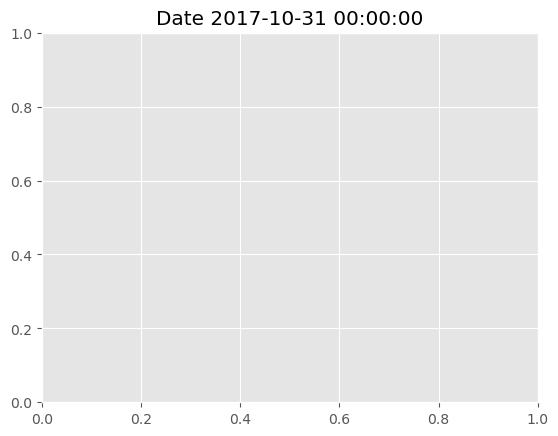

In [14]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

## 8. Visualize Portfolio returns and compare to SP500 returns.

In [ ]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

In [ ]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = 'C:/Users/user/Desktop/Python Scripts'

sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [ ]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [ ]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

In [ ]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [ ]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

## 6. Calculate Portfolio Returns with monthly rebalancing


In [ ]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
portfolio_df

## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [ ]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

In [ ]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

In [ ]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os

data_folder = 'C:/Users/user/Desktop/Python Scripts'

daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [ ]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [ ]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

In [ ]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

In [ ]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

## 5. Generate the position entry and hold until the end of the day.

In [ ]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

## 6. Calculate final strategy returns.

In [ ]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
                                                                            